In [47]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options
from qiskit.primitives import Estimator, Sampler
# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()
import numpy as np
import pylab
import qiskit_nature
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.units import DistanceUnit
qiskit_nature.settings.use_pauli_sum_op = False
from qiskit_nature.second_q.drivers import PySCFDriver
import matplotlib.pyplot as plt
from qiskit.circuit.library import EfficientSU2
import numpy as np
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP,SPSA,NFT

from qiskit import Aer
from qiskit.opflow import X, Z, I, Y
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP,SPSA,NFT
from qiskit.circuit.library import TwoLocal
from qiskit.primitives import Estimator, Sampler

In [50]:
H2_parity = (-1.052373245772859 * I ^ I) + \
        (0.39793742484318045 * I ^ Z) + \
        (-0.39793742484318045 * Z ^ I) + \
        (-0.01128010425623538 * Z ^ Z) + \
        (0.18093119978423156 * X ^ X)

In [51]:
H2_jw = (-0.81054798 * I^I ^ I^I) + \
        (-0.22575349 * I^I ^ I^Z) + \
        (0.17218393 * I^I ^ I^X) + \
        (0.12091263 * I^Z ^ I^Z) + \
        (0.17218393 * I^X ^ I^I) + \
        (0.16892754 * I^X ^ I^Z) + \
        (0.0452328 * Y^Y ^ Y^Y) + \
        (0.0452328 * X^X ^ X^X) + \
        (0.0452328 * Y^Y ^ X^X) + \
        (0.0452328 * X^X ^ Y^Y) + \
        (-0.22575349 * I^Z ^ I^I) + \
        (0.16614543 * I^Z ^ I^Z) + \
        (0.16614543 * I^X ^ Y^Y) + \
        (0.17464343 * Y^Y ^ X^X) + \
        (0.12091263 * I^Z ^ I^X)

In [43]:
H2_taper = (-1.0410931415166242 * I) + \
        (-0.7958748496863586 * Z) + \
        (-0.18093119978423122 * X)

In [52]:
def get_qubit_op_jw(dist):
    # Define Molecule
    driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 "+str(dist),
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
    )
    # Get properties
    problem = driver.run()

    num_particles = problem.num_particles
    num_spatial_orbitals = problem.num_spatial_orbitals
    
    mapper = JordanWignerMapper()
    #tapered_mapper = problem.get_tapered_mapper(mapper)
    qubit_op = mapper.map(problem.second_q_ops()[0])
    return qubit_op, num_particles, num_spatial_orbitals, problem, mapper

In [61]:
optimizers = [COBYLA(maxiter=100), L_BFGS_B(maxiter=100), SLSQP(maxiter=100),SPSA(maxiter=100),NFT(maxiter=100)]
converge_cnts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)

for i, optimizer in enumerate(optimizers):
    print('\rOptimizer: {}        '.format(type(optimizer).__name__), end='')
    algorithm_globals.random_seed = 50
    #ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
    ansatz = TwoLocal(1, rotation_blocks=['ry'],reps=0)
    (qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op_jw(
        0.735
    )
    '''
    ansatz = UCCSD(
        num_spatial_orbitals, num_particles, mapper, initial_state=init_state
    )
    '''
    counts = []
    values = []
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
    #quantum_instance=QuantumInstance(backend=Aer.get_backend('statevector_simulator'))
    backend=Aer.get_backend('statevector_simulator')
    
    vqe = VQE(ansatz, optimizer, callback=store_intermediate_result,
            quantum_instance=QuantumInstance(backend=Aer.get_backend('statevector_simulator')))
    result = vqe.compute_minimum_eigenvalue(operator=H2_parity)
    converge_cnts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)
print('\rOptimization complete      ');

Optimizer: COBYLA        

/tmp/ipykernel_6842/660259491.py:27: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance=QuantumInstance(backend=Aer.get_backend('statevector_simulator')))
/tmp/ipykernel_6842/660259491.py:26: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(ansatz, optimizer, callback=store_intermediate_result,


Optimizer: L_BFGS_B        

/tmp/ipykernel_6842/660259491.py:27: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance=QuantumInstance(backend=Aer.get_backend('statevector_simulator')))
/tmp/ipykernel_6842/660259491.py:26: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(ansatz, optimizer, callback=store_intermediate_result,


Optimizer: SLSQP        

/tmp/ipykernel_6842/660259491.py:27: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance=QuantumInstance(backend=Aer.get_backend('statevector_simulator')))
/tmp/ipykernel_6842/660259491.py:26: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(ansatz, optimizer, callback=store_intermediate_result,


Optimizer: SPSA        

/tmp/ipykernel_6842/660259491.py:27: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance=QuantumInstance(backend=Aer.get_backend('statevector_simulator')))
/tmp/ipykernel_6842/660259491.py:26: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(ansatz, optimizer, callback=store_intermediate_result,


Optimizer: NFT        

/tmp/ipykernel_6842/660259491.py:27: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance=QuantumInstance(backend=Aer.get_backend('statevector_simulator')))
/tmp/ipykernel_6842/660259491.py:26: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(ansatz, optimizer, callback=store_intermediate_result,


Optimization complete      


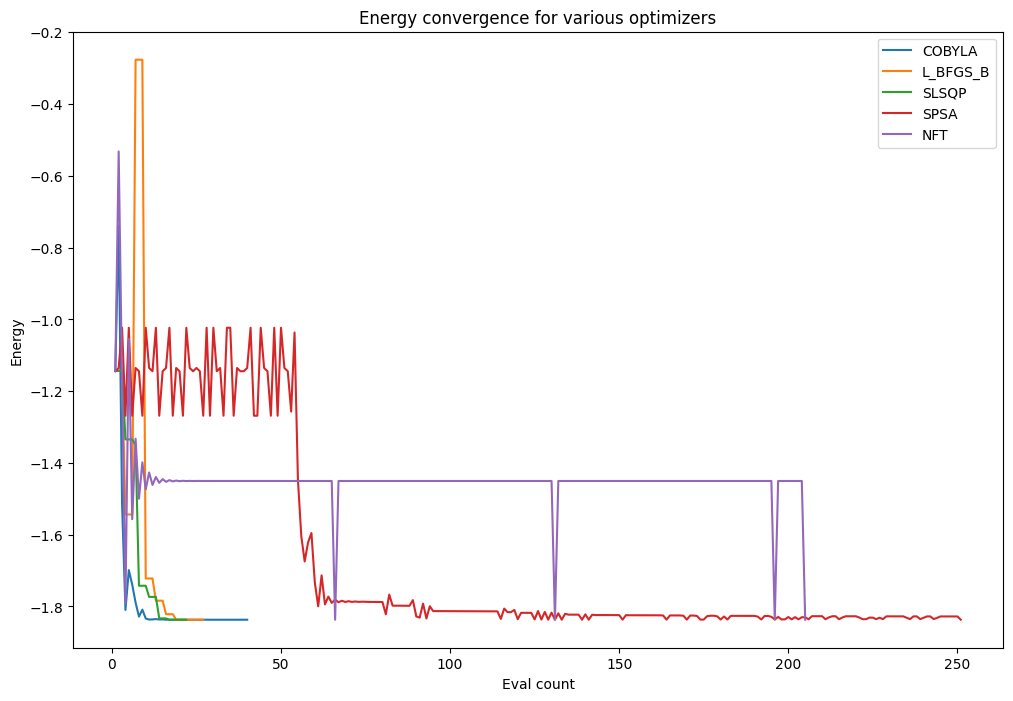

In [54]:
pylab.rcParams['figure.figsize'] = (12, 8)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_cnts[i], converge_vals[i], label=type(optimizer).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Energy convergence for various optimizers')
pylab.legend(loc='upper right');